# Part IIB: Solving Tic-Tac-Toe using $\varepsilon$-soft On-Policy Techniques

- Here, you will implement an On-Policy algorithm using $\varepsilon$-soft policies in order to make a Tic-Tac-Toe engine capable of playing Tic-Tac-Toe on an $N \times N$ board.

- You can read about the algorithm to be used in [my notes](../report.pdf) or in [Sutton and Barto](../SuttonBarto.pdf).

- The Tic-Tac-Toe engine must simulate episodes before hand and used the knowledge it gained to play against the human player.

- Since Tic-Tac-Toe is a two player game, the opponent must be simulated as part of the environment to convert this into an MDP. This can be done in two ways, either you can make the opponent another instance of the engine, or the opponent can play randomly. You will implement both these techniques.

In [1]:
import random


In [2]:
class TicTacToe:

    def __init__(self, n, players, mode=-1):
        self.board = [['-' for _ in range(n)] for _ in range(n)]
        self.n = len(self.board)
        self.players = players
        self.humans = []
        self.mode = mode  # -1: train, 0: human (O)
        self.current_player = 'X'
        self.G = 0

    def is_full(self, board):
        for row in board:
            if '-' in row:
                return False
        return True

    def evaluate(self, board):
        for row in board:
            if row.count(row[0]) == self.n and row[0] != '-':
                return 1 if row[0] == 'X' else -1

        for col in range(self.n):
            column = [board[i][col] for i in range(self.n)]
            if column.count(column[0]) == self.n and column[0] != '-':
                return 1 if column[0] == 'X' else -1

        diag1 = [board[i][i] for i in range(self.n)]
        if diag1.count(diag1[0]) == self.n and diag1[0] != '-':
            return 1 if diag1[0] == 'X' else -1

        diag2 = [board[i][self.n-i-1] for i in range(self.n)]
        if diag2.count(diag2[0]) == self.n and diag2[0] != '-':
            return 1 if diag2[0] == 'X' else -1

        return 0

    def train(self):
        current_player = 'X'
        players = {'X': 0, 'O': 1}
        while True:
            next_move = self.players[players[current_player]].find_move(self.board)
            if next_move is not None:
                row, col = next_move
                self.board[row][col] = current_player
            if self.evaluate(self.board) != 0 or self.is_full(self.board):
                break
            current_player = 'O' if current_player == 'X' else 'X'
        G = self.evaluate(self.board)
        self.G = G
        for player in self.players:
            player.G = G
        self.reset()
        return G

    def play_human(self):
        current_player = 'X'
        players = {'X': 0, 'O': 1}
        while True:
            if current_player == 'X':
                next_move = self.players[players[current_player]].find_move(self.board)
                if next_move is not None:
                    row, col = next_move
                    self.board[row][col] = current_player
                    print("Computer's move:")
                    self.print_board()
            else:
                while True:
                    try:
                        row = int(input("Enter row: "))
                        col = int(input("Enter column: "))
                        if self.board[row][col] == '-':
                            self.board[row][col] = current_player
                            break
                        else:
                            print("Invalid move. Try again.")
                    except (ValueError, IndexError):
                        print("Invalid input. Try again.")
                print("Your move:")
                self.print_board()
            if self.evaluate(self.board) != 0 or self.is_full(self.board):
                break
            current_player = 'O' if current_player == 'X' else 'X'
        G = self.evaluate(self.board)
        self.G = G
        for player in self.players:
            player.G = G
        self.reset()
        return G

    def play(self):
        if self.mode == -1:
            return self.train()
        elif self.mode in [0, 1]:
            return self.play_human()
        return 0

    def print_board(self):
        for row in self.board:
            print(' '.join(row))
        print()

    def reset(self):
        self.board = [['-' for _ in range(self.n)] for _ in range(self.n)]
        self.n = len(self.board)
        for player in self.players:
            player.reset()
        self.current_player = 'X'


In [4]:
class TicTacToeRandom:

    def __init__(self, n):
        self.board = [['-' for _ in range(n)] for _ in range(n)]
        self.n = len(self.board)
        self.G = 0

    def find_move(self, board):
        self.board = board
        legal_moves = []
        for i in range(len(board)):
            for j in range(len(board)):
                if board[i][j] == '-':
                    legal_moves.append((i, j))
        if len(legal_moves) > 0:
            next_move = legal_moves[random.randint(0, len(legal_moves) - 1)]
            return next_move
        return None

    def reset(self):
        self.board = [['-' for _ in range(self.n)] for _ in range(self.n)]
        self.n = len(self.board)


In [5]:
class TicTacToeEngine:

    def __init__(self, n, eps, train=True, Q={}, returns={}, policy={}):
        self.board = [['-' for _ in range(n)] for _ in range(n)]
        self.n = len(self.board)
        self.eps = eps
        self.state_action_pairs = []  # [(tuple_board, (i, j))]
        self.states = [] # [tuple_board]
        self.G = 0
        self.train = train
        self.Q = Q  # {(tuple_board, (i, j)): q}
        self.returns = returns  # {(tuple_board, (i, j)): [r]}
        self.policy = policy  # {tuple_board: (i, j)}
        self.state_actions = {}  # {tuple_board: [(i, j)]}

    def find_move(self, board):
        self.board = board
        tuple_board = self.get_tuple(board)

        if tuple_board not in self.Q:
            self.state_actions[tuple_board] = self.legal_moves()
            self.policy[tuple_board] = [self.eps / len(self.state_actions[tuple_board]) for _ in self.state_actions[tuple_board]]
            for action in self.state_actions[tuple_board]:
                self.Q[(tuple_board, action)] = 0

        next_move = random.choices(self.state_actions[tuple_board], weights=self.policy[tuple_board], k=1)[0]

        self.state_action_pairs.append((tuple_board, next_move))
        self.states.append(tuple_board)

        return next_move

    def evaluate(self, board):
        for row in board:
            if row.count(row[0]) == self.n and row[0] != '-':
                return 1 if row[0] == 'X' else -1

        for col in range(self.n):
            column = [board[i][col] for i in range(self.n)]
            if column.count(column[0]) == self.n and column[0] != '-':
                return 1 if column[0] == 'X' else -1

        diag1 = [board[i][i] for i in range(self.n)]
        if diag1.count(diag1[0]) == self.n and diag1[0] != '-':
            return 1 if diag1[0] == 'X' else -1

        diag2 = [board[i][self.n-i-1] for i in range(self.n)]
        if diag2.count(diag2[0]) == self.n and diag2[0] != '-':
            return 1 if diag2[0] == 'X' else -1

        return 0

    def legal_moves(self):
        legal_moves = []
        for i in range(self.n):
            for j in range(self.n):
                if self.board[i][j] == '-':
                    legal_moves.append((i, j))
        return legal_moves

    def get_tuple(self, board):
        new_board = tuple(tuple(row) for row in board)
        return new_board

    def reset(self):
        for state_action_pair in self.state_action_pairs:
            if state_action_pair not in self.returns:
                self.returns[state_action_pair] = []
            self.returns[state_action_pair].append(self.G)
            self.Q[state_action_pair] = sum(self.returns[state_action_pair]) / len(self.returns[state_action_pair])
        for state in self.states:
            max_action = None
            max_Q = float('-inf')
            for action in self.state_actions[state]:
                if self.Q[(state, action)] > max_Q:
                    max_action = action
                    max_Q = self.Q[(state, action)]
            self.policy[state] = [self.eps / len(self.state_actions[state]) for _ in self.state_actions[state]]
            self.policy[state][self.state_actions[state].index(max_action)] = 1 - self.eps + self.eps / len(self.state_actions[state])
            

        self.state_action_pairs = []
        self.states = []


def print_tuple(states):
    for state in states:
        for row in state:
            print(row)
        print()

2419


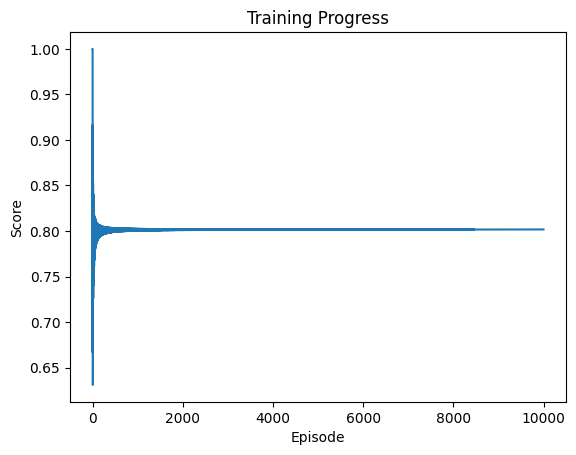

In [6]:
import matplotlib.pyplot as plt

n = 3
episodes = 10000
eps = 0.1

'''
Training by playing against itself
'''

engine_self_play = TicTacToeEngine(n, eps)

players = [engine_self_play, TicTacToeRandom(n)]
game = TicTacToe(n, players)
G_avg = []
for i in range(episodes):
    G_avg.append((sum(G_avg) + game.train()) / (len(G_avg) + 1))

print(len(engine_self_play.policy))

# Plot the scores
plt.plot([score_avg for score_avg in G_avg])
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Training Progress')
plt.show()

In [7]:
players = [engine_self_play]
game = TicTacToe(n, players, 0)
game.play()

Computer's move:
- - -
- X -
- - -

